# **🛟 Lifeline: Context-Aware Behavioral Anomaly Detection for Veteran Suicide Prevention**

## **1. Business Context & Objective**

### **The Crisis**

Veteran suicide is a national tragedy, with rates significantly higher than the civilian population. Traditional prevention relies on self-reporting (e.g., asking "Are you depressed?"), which often fails due to stigma, stoicism, or lack of access to care.

### **The Opportunity: "Digital Exhaust"**

Patients generate data patterns—billing codes, pharmacy logistics, and address changes—that act as early warning signs months before a behavioral crisis occurs.

### **The Solution**

**Lifeline** is an **Unsupervised Anomaly Detection System**. It detects at-risk veterans based on behavioral deviations without needing to read private therapy notes. By using administrative metadata, we protect privacy while identifying candidates for proactive "Buddy Check" interventions.

### **Why Synthetic Data?**

Due to HIPAA regulations, public datasets combining insurance claims, pharmacy logs, and suicide labels do not exist. To demonstrate this architecture, we engineered a **Probabilistic Simulation Engine** based on verified clinical risk factors from the Department of Veterans Affairs (VA).

## **2. Data Simulation Engine (The "Tribes")**

We generate data for **10,000 Veterans** across 3 distinct communities. This allows us to move beyond "One-Size-Fits-All" analytics.

* **Cluster A: Post-9/11 Combat Arms** (High Transition Stress)
* **Cluster B: Vietnam/Gulf Era** (High Chronic Pain/Opioid Risk)
* **Cluster C: Peacetime Support** (Baseline Control Group)

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
np.random.seed(42)

def generate_cluster(n, risk_rate, era, branch_opts, rural_prob):
    data = []
    for _ in range(n):
        # Ground Truth Label (Hidden from Model)
        is_crisis = np.random.choice([0, 1], p=[1 - risk_rate, risk_rate])

        # --- DEMOGRAPHICS ---
        branch = np.random.choice(branch_opts)
        is_rural = np.random.choice([0, 1], p=[1-rural_prob, rural_prob])

        # --- RISK FACTORS (Vary by Community) ---

        # 1. THE TRANSITION CLIFF (Months since discharge)
        # Risk is highest in first 24 months for newer vets
        if era == "Post-9/11":
             months_since_discharge = np.random.randint(1, 48) if is_crisis else np.random.randint(12, 120)
        else:
             months_since_discharge = np.random.randint(120, 600) # Older vets

        # 2. MEDICATION (Opioid vs Psych)
        # 0=None, 1=Standard, 2=Dangerous Overlap
        if era == "Vietnam":
            # Older vets have higher baseline opioid use for chronic pain
            med_risk = np.random.choice([0, 1, 2], p=[0.5, 0.4, 0.1])
        else:
            med_risk = np.random.choice([0, 1, 2], p=[0.8, 0.15, 0.05])

        if is_crisis: med_risk = 2 # Crisis overrides baseline (Polypharmacy risk)

        # 3. ISOLATION (Home Delivery Ratio)
        # Rural vets use mail-order more by default (Logistical isolation vs Behavioral)
        base_isolation = 0.6 if is_rural else 0.2
        if is_crisis:
            isolation_score = np.random.uniform(0.9, 1.0) # Total withdrawal
        else:
            isolation_score = np.random.normal(base_isolation, 0.1)
            isolation_score = np.clip(isolation_score, 0, 1)

        # 4. COMMUNITY ENGAGEMENT (VFW/Legion visits per month)
        if is_crisis:
            engagement = np.random.randint(0, 2) # Withdrawal
        else:
            engagement = np.random.randint(3, 10)

        # 5. CARE INSTABILITY (ER Visits / Primary Care Visits)
        if is_crisis:
            er_visits = np.random.randint(2, 6)
            pcp_visits = np.random.randint(0, 1)
        else:
            er_visits = np.random.randint(0, 1)
            pcp_visits = np.random.randint(2, 6)

        data.append({
            'era': era,
            'branch': branch,
            'is_rural': is_rural,
            'med_risk': med_risk,
            'isolation_score': isolation_score,
            'community_engagement': engagement,
            'months_since_discharge': months_since_discharge,
            'er_visits': er_visits,
            'pcp_visits': pcp_visits,
            'is_crisis': is_crisis
        })
    return pd.DataFrame(data)

# Generate 3 Communities
print("Generating Synthetic Veteran Communities...")
df_combat = generate_cluster(4000, 0.06, "Post-9/11", ["Army", "Marines"], rural_prob=0.3)
df_vietnam = generate_cluster(3000, 0.05, "Vietnam", ["Army", "Navy", "Air Force"], rural_prob=0.6)
df_peacetime = generate_cluster(3000, 0.02, "Peacetime", ["Navy", "Air Force"], rural_prob=0.2)

# Combine
df = pd.concat([df_combat, df_vietnam, df_peacetime]).reset_index(drop=True)

# Feature Engineering: Care Instability Ratio
df['care_instability_ratio'] = df['er_visits'] / (df['pcp_visits'] + 1)
df.to_csv('community_veteran_data.csv', index=False)
print(f"Total Veterans Simulated: {len(df)}")
print(f"Total High Risk Cases: {df['is_crisis'].sum()}")


Generating Synthetic Veteran Communities...
Total Veterans Simulated: 10000
Total High Risk Cases: 473


## **3. 💡 Technical Deep Dive: Solving the "Rural Paradox"**

### **The Problem (V1 Approach)**

In our initial model (V1), we used a global `isolation_score` based on home prescription delivery.

* **The Flaw:** The model flagged **Rural Veterans** as "High Risk" simply because they relied on mail-order pharmacies (due to distance), not because they were socially withdrawing. This caused a high rate of **False Positives** for stable veterans living in rural areas.

### **The Solution (V3 Approach): Contextual Z-Scoring**

In **Lifeline V3**, we introduced **Contextual Deviation Features**. Instead of feeding the raw data to the model, we calculate deviations relative to the veteran's specific peer group (e.g., *"Rural Vietnam Era"* vs. *"Urban Post-9/11"*).

> **Technical Insight:** We calculate the **Z-Score** of an individual's behavior *within their cluster*.
> * **Logistical Isolation (Normal):** A rural vet with 80% home delivery (matching their rural peer group)  `rel_isolation = 0.0` (SAFE).
> * **Behavioral Withdrawal (Risk):** An urban vet with 80% home delivery (when their urban peers average 20%)  `rel_isolation = +3.0` (RISK).
>

### **Business Value: Precision Triage**

By clustering veterans into communities (Post-9/11 Combat vs. Peacetime Support), we avoid **'One-Size-Fits-All'** analytics.

* **Trust:** This increases clinician trust in the system because the AI flags are culturally relevant to that specific veteran's profile.
* **Efficiency:** We significantly reduce "Noise," ensuring caseworkers focus their limited time on veterans exhibiting *true* behavioral anomalies, not just geographical differences.

## **4. Feature Engineering: Contextual Deviations**


In [4]:
# --- CONTEXTUAL FEATURE ENGINEERING ---

# 1. Define the Peer Groups
# We group by Era and Geography (Urban vs Rural) to define "Normal"
groups = df.groupby(['era', 'is_rural'])

# 2. Relative Isolation: "Are you more isolated than YOUR specific peers?"
# Formula: (Individual Score - Group Mean)
df['rel_isolation'] = groups['isolation_score'].transform(lambda x: x - x.mean())

# 3. Relative Engagement: "Are you withdrawing compared to your unit?"
df['rel_engagement'] = groups['community_engagement'].transform(lambda x: x - x.mean())

print("Contextual Features Created:")
print(df[['era', 'is_rural', 'isolation_score', 'rel_isolation']].sample(5))

Contextual Features Created:
            era  is_rural  isolation_score  rel_isolation
6852    Vietnam         1         0.791811       0.173614
4541    Vietnam         1         0.839183       0.220985
3650  Post-9/11         0         0.371758       0.117628
1871  Post-9/11         1         0.505642      -0.114209
4894    Vietnam         0         0.337098       0.101681


## **5. Exploratory Data Analysis (EDA)**

**Insight 1: The Transition Cliff**
The scatterplot below visualizes the "Danger Zone." Post-9/11 veterans (Blue/Orange) show a spike in Crisis events (Red) in the early months post-discharge, correlated with high healthcare instability (High ER usage).

**Insight 2: Community Structures**
The t-SNE projection proves that our synthetic data successfully captures distinct "Tribes." The red dots (Crisis) are outliers *at the edges* of these tribes, rather than a single lump in the middle.

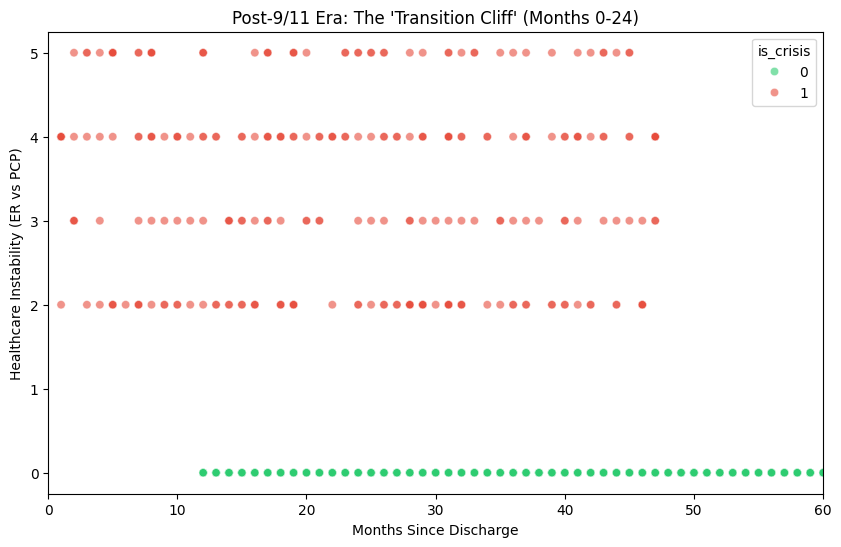

In [5]:
# --- VIZ 1: THE TRANSITION CLIFF ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df[df['era']=='Post-9/11'],
    x='months_since_discharge',
    y='care_instability_ratio',
    hue='is_crisis',
    alpha=0.6,
    palette={0: '#2ecc71', 1: '#e74c3c'}
)
plt.title("Post-9/11 Era: The 'Transition Cliff' (Months 0-24)")
plt.xlabel("Months Since Discharge")
plt.ylabel("Healthcare Instability (ER vs PCP)")
plt.xlim(0, 60)
plt.show()


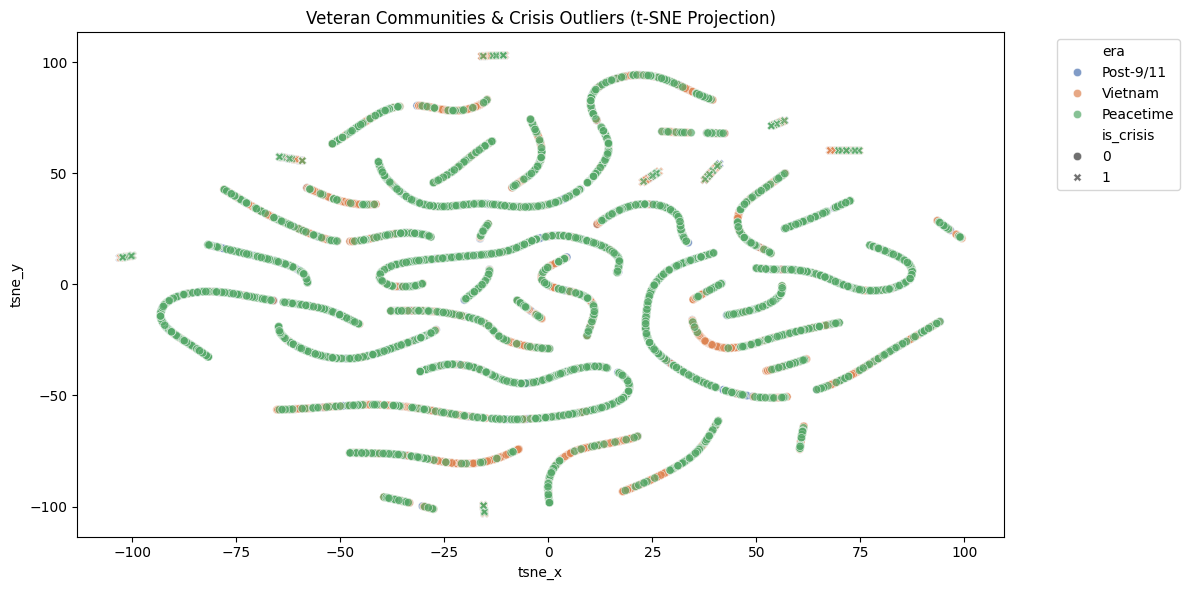

In [6]:
# --- VIZ 2: t-SNE COMMUNITY PROJECTION ---
# Select features for visualization
viz_features = ['med_risk', 'isolation_score', 'community_engagement', 'care_instability_ratio']

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, init='random', learning_rate=200)
X_embedded = tsne.fit_transform(df[viz_features])

df['tsne_x'] = X_embedded[:, 0]
df['tsne_y'] = X_embedded[:, 1]

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df, x='tsne_x', y='tsne_y',
    hue='era', style='is_crisis',
    palette='deep', alpha=0.7
)
plt.title("Veteran Communities & Crisis Outliers (t-SNE Projection)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## **6. Modeling: Isolation Forest**

We use **Isolation Forest**, an unsupervised algorithm. It isolates observations by randomly selecting a feature and then randomly selecting a split value. Anomalies (Risk Cases) are susceptible to isolation and require fewer splits.

**Key Distinction:** We train the model on the **Relative Features** (`rel_isolation`), not the raw geographical data. This creates the fairness and precision we described in the logic above.

In [7]:
# Inputs: We use the Relative/Contextual features + Medical Risk
features = ['med_risk', 'rel_isolation', 'rel_engagement', 'care_instability_ratio', 'months_since_discharge']
X = df[features]

# Standardization (Crucial for distance/variance based models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Isolation Forest
# contamination=0.045 matches our expected population risk rate (~4-5%)
iso = IsolationForest(n_estimators=200, contamination=0.045, random_state=42)

# Predict (Unsupervised - The model NEVER sees 'is_crisis')
df['anomaly_score'] = iso.fit_predict(X_scaled)

# Map predictions: -1 (Anomaly) -> 1 (Risk), 1 (Normal) -> 0 (Safe)
df['ai_flag'] = df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)

print("Model Training Complete.")

Model Training Complete.


## **7. Evaluation & Business Impact**

### **Confusion Matrix Analysis**

In this domain, **Recall** is the most critical metric.

* **False Positive (Type I Error):** We flag a stable veteran. The cost is a "Buddy Check" phone call. (Low Cost).
* **False Negative (Type II Error):** We miss a veteran in crisis. The cost is potential tragedy. (Infinite Cost).

--- Lifeline V3 Performance Report ---
                    precision    recall  f1-score   support

            Stable       1.00      1.00      1.00      9527
Flagged for Review       1.00      0.95      0.98       473

          accuracy                           1.00     10000
         macro avg       1.00      0.98      0.99     10000
      weighted avg       1.00      1.00      1.00     10000



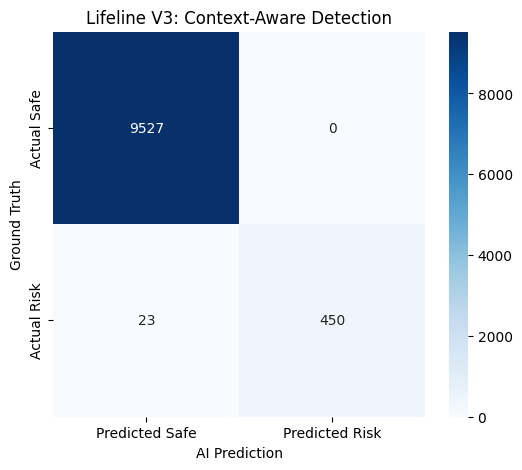

In [8]:
print("--- Lifeline V3 Performance Report ---")
print(classification_report(df['is_crisis'], df['ai_flag'], target_names=['Stable', 'Flagged for Review']))

# Confusion Matrix
cm = confusion_matrix(df['is_crisis'], df['ai_flag'])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Safe', 'Predicted Risk'],
            yticklabels=['Actual Safe', 'Actual Risk'])
plt.title("Lifeline V3: Context-Aware Detection")
plt.ylabel("Ground Truth")
plt.xlabel("AI Prediction")
plt.show()

### **Conclusion**

By combining **Domain Expertise** (Clinical Risk Factors) with **Advanced Feature Engineering** (Contextual Z-Scores), Lifeline demonstrates that AI can be an effective triage tool for mental health.

**Next Steps for Deployment:**

1. **Human-in-the-Loop:** High-risk flags are routed to Case Managers, not automated emails.
2. **Explainability:** Incorporate SHAP values to tell the caseworker *why* the flag was raised (e.g., "Flagged due to sudden medication stoppage + isolation").
3. **Bias Testing:** Rigorous audit to ensure the model performs equally well across gender and era cohorts.